In [149]:
library(bnlearn) |> suppressPackageStartupMessages()
library(Rgraphviz) |> suppressPackageStartupMessages()
library(tidyverse) |> suppressPackageStartupMessages()
suppressWarnings(library(dplyr))
library(gtools) |> suppressPackageStartupMessages()
library(parallel) |> suppressPackageStartupMessages()
library(igraph) |> suppressPackageStartupMessages()
library(bnstruct)  |> suppressPackageStartupMessages()

In [150]:
factor_remover <- function(dataset) {
    cols <- colnames(dataset)
    for (i in seq_along(cols)) {
        name <- cols[i]
        dataset[[name]] <- as.character(dataset[[name]])
    }
    return(dataset)
}
df <- learning.test
#print(sapply(df, class))
df <- factor_remover(df)



In [151]:


node.values <- function(dataset, parents) {
    # retrieves the unique values of the nodes
    #return a list of vectors, 
    # each vector contains the unique values of the corresponding node
    output <- list()
    for (kk in seq_along(parents)) {
        node <- parents[kk]
        node.vals <- unique(dataset[[node]]) #it was levels()
        output[[kk]] <- node.vals
    }
    return(output)
}


In [152]:

fastalphaijk <- function(i, pii, dataset, nodes.order, smooth=FALSE) {
    actual_node <- nodes.order[i]
    all.nodes <- c(pii, actual_node)
    subset <- dataset[all.nodes]
    unique.instantiations <- expand.grid(node.values(dataset, all.nodes))
    colnames(unique.instantiations) <- colnames(subset)
    subset.counted <- subset |> group_by(across(everything())) |> summarise(n = n(), .groups="drop")
    checking <-  left_join(unique.instantiations, subset.counted, by=colnames(subset), na_matches="na")  |> arrange(across(-last_col()))
    checking$n[is.na(checking$n)]<- 0
    if (smooth) {
        checking$n <- checking$n + 1   # SOFIA's laplace smoothing
    } else {}
    #cat("\n")
    #print(checking)
    #cat( "\n \n")
    return(checking$n)
}

In [153]:

k2helper <- function(i, pii, dataset, nodes.order, log=TRUE) {
    # the "f" function in the pdf
    #cat("\n------------------\n")
    phi_i <- expand.grid(node.values(dataset, pii)) 
    #cat("\nphi.i")
    #print( phi_i)
    q_i <- dim(phi_i)[1] # works good
    #cat("\nqi.i", q_i)
    i.th.node <- nodes.order[i]
    #cat("\nithnode", i.th.node)
    v_i <- node.values(dataset, i.th.node)
    #cat("\nvi")
    #print(v_i)
    r_i <- length(v_i[[1]])
    #cat("\nri", r_i)
    individual_alphas <- fastalphaijk(i, pii, dataset, nodes.order) # works good
    #cat("\nindividual alphas::",individual_alphas)
    #aijk <- prod(factorial(individual_alphas)) ##
    grouping_alphas <- matrix(individual_alphas, nrow=r_i) # to get the right Nijs
    nij <- colSums(grouping_alphas)
    #print(nij)
    
    produttoria_alpha <- prod(lfactorial(individual_alphas))
    log_produttoria_alpha <- sum(lfactorial(individual_alphas))
    log_numeratore <- sum(lfactorial(rep(r_i-1,q_i))) # r_i - 1 + 1 = r_i
    numeratore <- factorial(r_i-1)
    log_denominatore <- sum(lfactorial(nij + r_i-1)) # nij + r_i - 1 + 1 = nij + r_i
    denominatore <- factorial(nij+r_i-1)
    log_out <- log_numeratore - log_denominatore + log_produttoria_alpha
    out1 <- prod((numeratore/denominatore))*produttoria_alpha
    out2 <- sum(log_out)
    #cat("logout", log_out)
    ifelse(log, out <- out2, out<- out1)
    #cat("\nproduttoria_alpha",produttoria_alpha )
    #cat("\nproduttoria_alpha",produttoria_alpha )
    #print(frazione)
    return(out)
}



In [154]:

k2 <- function(dataset, nodes.order, upperbound) {
    start <- Sys.time()  # SOFIA

    edges <- list()  # ← new: store edges here  SOFIA
    
    nodes <- colnames(dataset)
    for (i in seq_along(nodes.order)) {
        actual_node <- nodes.order[i]
        #cat("\n", i,"\n")
        pii <- c()
        p.old <- k2helper(i, pii,dataset, nodes.order)
        proceed <- TRUE
        #cat("\ni::",i, "\n")
        p.new.container <- c()
        while (proceed && length(pii) <= upperbound) {
            predecessors_idx <- i-1
            predecessors <- nodes.order[0:predecessors_idx]
            #cat("\npredecessors::", predecessors, " pii:: ", pii)
            piiuz <- setdiff(predecessors, pii)
            if (length(piiuz) > 1) {
                daddy.s.probs <- c()
                for (daddy in seq_along(piiuz)) {
                    p.new <- k2helper(i, c(pii, piiuz[daddy]), dataset, nodes.order)
                    daddy.s.probs <- c(daddy.s.probs, c(p.new))
                }
                p.new <- max(daddy.s.probs)
                #cat("\npnew", p.new, "pold", p.old)
                eventuale.genitore <-  piiuz[daddy.s.probs == p.new]
            } else {
                p.new <- k2helper(i, piiuz, dataset, nodes.order)
                eventuale.genitore <- piiuz
            }
            #cat("\npiiuz:: ",piiuz,"\np.old:: ", p.old, "\np.new:: ", p.new)    #edge_matrix <- do.call(rbind, edges)

            #roof <- roof+1
            if (p.new > p.old) {
                p.old <- p.new
                pii <- c(pii, eventuale.genitore)
                p.new.container <- c(p.new.container, p.new)
                #ifelse(roof>length(nodes)^length(nodes), proceed <- FALSE, proceed <- TRUE)
            } else  {
                proceed <- FALSE
            }
        }
        #cat('\nNode', nodes.order[i], '--> Parents:', pii,'\n') 
        
        # Store edges: each pii is a parent of actual_node  SOFIA
        if (length(pii) >= 0) {
            for (iterator in seq_along(pii)) {
                parent <- pii[iterator]
                edges[[length(edges) + 1]] <- c(parent, actual_node, p.new.container[iterator])
            }
        }

    }
    end <- Sys.time()
    execution_time <- difftime(time1 = end, time2 = start, units = "secs") 
    cat("\nExecution Time:", execution_time, "s")

    # Convert to matrix or return edge list
    edge_matrix <- do.call(rbind, edges)
    return(edge_matrix)
}



Execution Time: 0.8455694 s

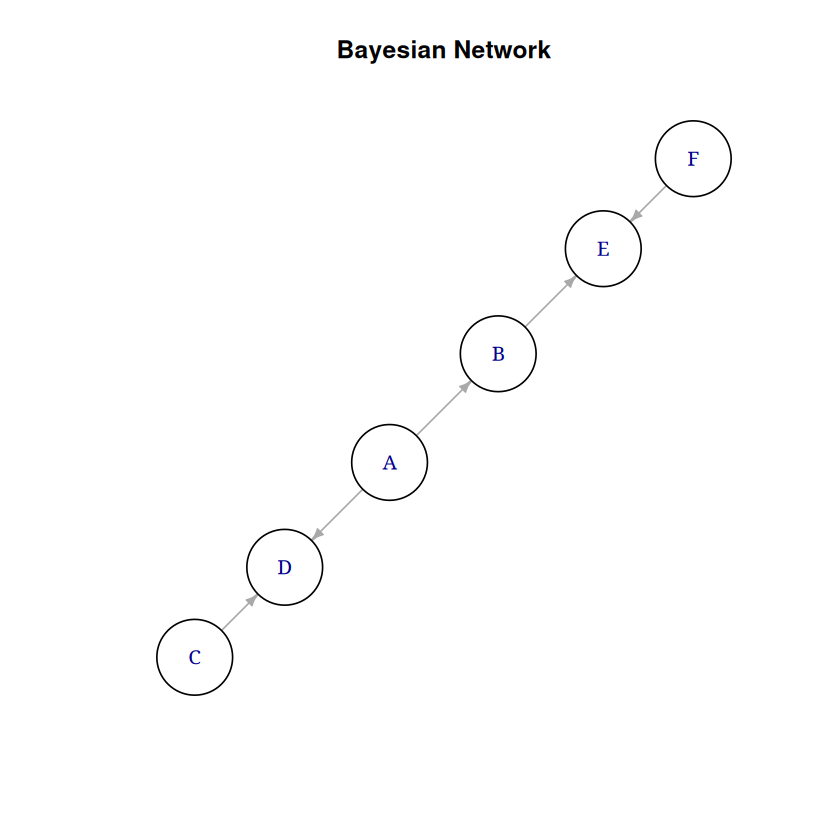

In [155]:
learning_edges <- k2(dataset=df, upperbound = 3, nodes.order = c("A","B","C","D","F","E"))
#edges2 <- k2(dataset=df, upperbound = 3, nodes.order = c("C","F","A","B","D","E"))

g <- graph_from_edgelist(learning_edges[,1:2], directed = TRUE)

# Plot it
plot(g,
     vertex.color = "white",
     vertex.size = 30,
     edge.arrow.size = 0.5,
     #layout = layout_as_tree,
     main = "Bayesian Network")

[1] "Asia"         "Tubercolosys" "Smoke"        "LungCancer"   "Bronchitis"  
[6] "Either"       "X-ray"        "Dyspnea"     

Execution Time: 1.043399 s

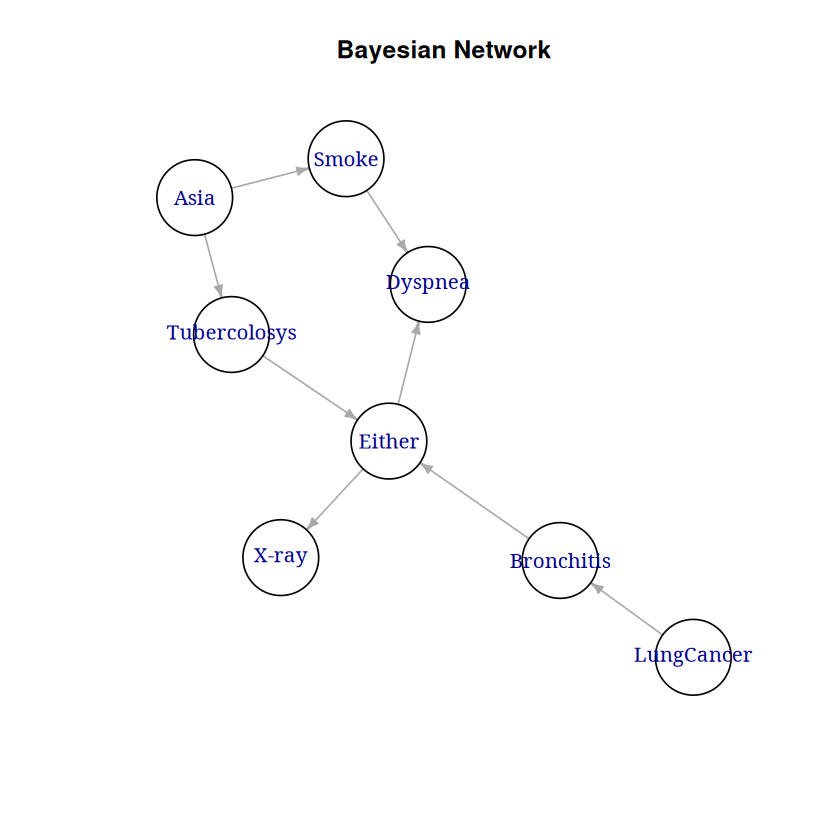

In [156]:
asia_dataset <- asia()
asia_df <- as.data.frame(raw.data(asia_dataset))
print(asia_dataset@variables)
colnames(asia_df) <- asia_dataset@variables
ordering_asia <- colnames(asia_df)[c(3,1,2,4,5,6,7,8)]
asian_edges <-k2(asia_df, upperbound=3, nodes.order=colnames(asia_df))

g <- graph_from_edgelist(asian_edges[,1:2], directed = TRUE)

# Plot it
plot(g,
     vertex.color = "white",
     vertex.size = 30,
     edge.arrow.size = 0.5,
     #layout = layout_as_tree,
     main = "Bayesian Network")


Execution Time: 7.730115 s

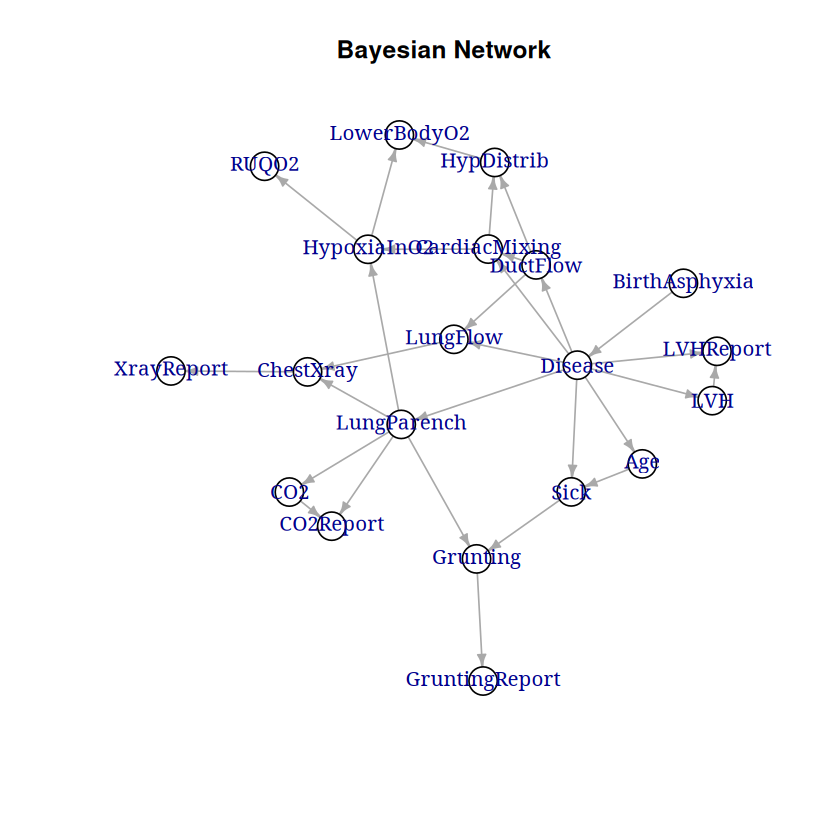

In [157]:
child_dataset <- child()
child_df <- as.data.frame(raw.data(child_dataset))
colnames(child_df) <- child_dataset@variables
ordering_asia <- colnames(child_df)
child_edges <-k2(child_df, upperbound=3, nodes.order=colnames(child_df))

g <- graph_from_edgelist(child_edges[,1:2], directed = TRUE)

# Plot it
plot(g,
     vertex.color = "white",
     vertex.size = 10,
     edge.arrow.size = 0.5,
     #layout = layout_as_tree,
     main = "Bayesian Network")

In [158]:
child_edges

BirthAsphyxia,Disease,-8451.85801295105
Disease,Age,-5485.60163013371
Disease,LVH,-3678.36609956984
Disease,DuctFlow,-4380.5695374678
Disease,CardiacMixing,-4692.93086738703
DuctFlow,CardiacMixing,-4638.83876675713
Disease,LungParench,-4933.10563155547
Disease,LungFlow,-5050.31143622382
DuctFlow,LungFlow,-5007.96614037002
Disease,Sick,-4285.15606902641
Age,Sick,-4236.0921204913
